# Classificação de conteúdo gerado por IA utilizando DistilBERT
## Panda 2024/2025 - Universidade Federal de São Carlos

Grupo de Processamento de Linguagem Natural

Apresentação final - 14/01/2025

## Instruções de Fine tuning de Transformers para Classificação de Textos

**Introdução**  
Neste tutorial, faremos o fine tuning de um modelo transformer para o problema de classificação de texto binária. Este é um dos problemas de negócios mais comuns, onde um dado texto/frase/documento precisa ser classificado em uma ou mais categorias de uma lista fornecida. Por exemplo, um filme pode ser categorizado em um ou mais gêneros.

**Fluxo do Notebook**  
O notebook será dividido em seções separadas para fornecer um guia organizado sobre o processo utilizado. Este processo pode ser modificado para casos de uso individuais. As seções são:

- Importação de Bibliotecas Python e preparação do ambiente  
- Importação e Pré-Processamento dos dados do domínio  
- Preparação do Dataset e Dataloader  
- Criação da Rede Neural para Fine Tuning  
- Fine Tuning do Modelo  
- Validação do Desempenho do Modelo  
- Salvando o modelo e artefatos para Inferência no Futuro  


**Dados:**
Em cada linha temos um texto na coluna ```text```, com o valor de 0 na coluna ```generated``` para textos escritos por humanos. Ao contrário, o valor é 1.

Para nosso trabalho, utilizamos 30000 exemplos do dataset.

**Modelo de Linguagem Utilizado:**  
O DistilBERT vai ser utilizado neste projeto. Ele é um modelo transformer criado pela equipe do Hugging Face.

**NOTA**  
Deve-se notar que as saídas do modelo BERT são diferentes do modelo DistilBert implementado pela equipe Hugging Face. Não há `token_type_ids` gerados pelo tokenizer no caso do DistilBert e também as saídas finais da rede diferem.  
Isso será explicado mais adiante no notebook.

**Requisitos de Hardware:**  
- Python 3.6 ou superior  
- Pytorch, Transformers e todas as bibliotecas padrão de ML do Python  
- Configuração com GPU habilitada  


**Importação de Bibliotecas Python e Preparação do Ambiente**  
Nesta etapa, importaremos as bibliotecas e módulos necessários para executar nosso script. As bibliotecas são:  
- Pandas  
- Pytorch  
- Utils do Pytorch para Dataset e Dataloader  
- Transformers  
- Modelo DistilBERT e Tokenizer  

Em seguida, prepararemos o dispositivo para execução com GPU. Esta configuração é necessária se você deseja aproveitar a GPU integrada.


In [ ]:
# Instalando bibliotecas
!pip install -q transformers torch

In [ ]:
# Importando bibliotecas de ML
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig

CUDA é um framework criado pela Nvidia (disponível somente em gpus da mesma) para programação paralela. É extremamente importante para a otimização de redes neurais, dado que GPUs possuem maior capacidade de processamento para cálculos, e Redes Neurais são treinadas a partir de extensas multiplicações de matrizes.
A utilização de batches também é importante para otimização, pois as amostras dentro do batch são processadas paralelamente.


In [ ]:
from torch import cuda

# Retorna se é possível utilizar cuda (há gpu e driver instalados)
cuda.is_available()

True

In [ ]:
# Utiliza processamento em CPU caso não seja possível usar CUDA
# Interfere diretamente no tempo de execução do modelo
# CUDA > CPU
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

**Importação e Pré-Processamento dos Dados do Domínio**  
Trabalharemos com os dados e os prepararemos para fins de fine tuning. Assumindo que o arquivo `AI_Human_small.csv` já foi baixado, descompactado e salvo na sua pasta de dados.

Importe o arquivo para um dataframe e atribua os cabeçalhos conforme a documentação.  


In [ ]:
%ls

AI_Human_small.csv  sample_data/


In [ ]:
import pandas as pd
df = pd.read_csv("AI_Human_small.csv", header=0, nrows=30000)
df.head()

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0


In [ ]:
df["generated"].value_counts()

,count
generated,
0.0,16095
1.0,13905



**Preparação do Dataset e Dataloader**  
Começaremos definindo algumas variáveis-chave que serão usadas posteriormente durante a etapa de treinamento/fine tuning. Em seguida, criaremos a classe `CustomDataset` - que define como o texto é pré-processado antes de ser enviado para a rede neural. Também definiremos o `Dataloader`, que alimentará os dados em lotes para a rede neural, facilitando o treinamento e processamento. `Dataset` e `Dataloader` são construções da biblioteca PyTorch para definir e controlar o pré-processamento dos dados e sua passagem para a rede neural. Para mais informações sobre `Dataset` e `Dataloader`, consulte a documentação do PyTorch.

**Classe CustomDataset**  
Esta classe é definida para aceitar o `tokenizer`, o `dataframe` e o `max_length` como entrada e gerar a saída tokenizada e as tags que serão usadas pelo modelo BERT para treinamento.  
Estamos usando o tokenizer do BERT para tokenizar os dados na coluna `comment_text` do dataframe.  
O tokenizer utiliza o método `encode_plus` para realizar a tokenização e gerar as saídas necessárias, a saber: `ids`, `attention_mask`, `token_type_ids`.  
Esta é a primeira diferença entre o DistilBert e o BERT, onde o tokenizer gera os `token_type_ids` no caso do BERT.  
Para mais informações sobre o tokenizer, consulte este documento.  
`targets` é a lista de categorias rotuladas como 0 ou 1 no dataframe.  
A classe `CustomDataset` é usada para criar dois datasets: um para treinamento e outro para validação.  
- O Dataset de Treinamento é usado para o fine tuning do modelo: 80% dos dados originais.  
- O Dataset de Validação é usado para avaliar o desempenho do modelo. O modelo não viu esses dados durante o treinamento.



In [ ]:
# Configurações de seed
seed = 42
torch.manual_seed(seed)  # PyTorch random seed (CPU)
torch.cuda.manual_seed(seed)  # PyTorch random seed (GPU)
torch.backends.cudnn.deterministic = True

# Definindo variáveis para os próximos passos
MAX_LEN = 200
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
EPOCHS = 3
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained('distilbert-base-uncased')

In [ ]:
class CustomDataset(Dataset):

    # Atributos
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe.text
        self.target = dataframe.generated
        self.max_len = max_len
        self.idx = dataframe.index

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        # Converte a sequência para uma lista de ids do vocabulário
        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",  # Ensures all sequences are padded to max_len
            truncation=True,
        )

        # Ids e máscara
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        # Retorna em formato de tensor
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'target': torch.tensor(self.target[index], dtype=torch.float),
            'idx': self.idx[index]
        }

Separação do dataset em treino e teste (80% treino e 20% teste)

Cria objetos da classe CustomDataset

In [ ]:
train_size = 0.8
train_dataset=df.sample(frac=train_size,random_state=200)
test_dataset=df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (30000, 2)
TRAIN Dataset: (24000, 2)
TEST Dataset: (6000, 2)


**Dataloader**  
O `Dataloader` é usado para criar os dataloaders de treinamento e validação que carregam os dados para a rede neural de maneira definida. Isso é necessário porque todos os dados do dataset não podem ser carregados na memória de uma só vez, portanto, a quantidade de dados carregada na memória e, em seguida, passada para a rede neural precisa ser controlada.  
Esse controle é alcançado usando parâmetros como `batch_size` e `max_len`.  
Os dataloaders de Treinamento e Validação são usados, respectivamente, nas partes de treinamento e validação do fluxo.

In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

## Configuração da Rede Neural

Vamos criar uma rede neural com a classe DistilBERT.
Essa rede terá o modelo Distilbert, seguido por uma camada de Dropout e uma Camada Linear. Elas são adicionadas para os propósitos de Regularização e Classificação, respectivamente.

### Treinamento

No loop de forward, há 2 saídas da camada DistilBertModel.

A segunda saída, output_1, ou chamada de pooled output, é passada para a camada de Dropout, e o resultado subsequente é enviado para a Camada Linear.


É importante notar que o número de dimensões para a Camada Linear é 1, porque esse é o total de categorias nas quais buscamos classificar nosso modelo.

Os dados serão alimentados na DistilBERTClass conforme definido no dataset.

A saída da camada final será usada para calcular a perda e determinar a acurácia das previsões do modelo.

Vamos inicializar uma instância da rede chamada model. Essa instância será usada para treinamento e, posteriormente, para salvar o modelo treinado para futuras inferências.


### Função de Perda e Otimizador

A função de perda é definida na próxima célula como loss_fn.

Conforme mencionado acima, a função de perda utilizada será uma combinação de Binary Cross Entropy, implementada como BCELogits Loss no PyTorch.

O Otimizador é definido na próxima célula.

O Otimizador é usado para atualizar os pesos da rede neural, melhorando seu desempenho.

In [ ]:
class DistilBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistilBERTClass, self).__init__()
        # Modelo DiltilBert pré treinado
        self.l1 = transformers.DistilBertModel.from_pretrained('distilbert-base-uncased')
        # Camada de dropout
        self.l2 = torch.nn.Dropout(0.3)
        # Camada linear
        self.l3 = torch.nn.Linear(768, 1)

    # Aplicação das camadas
    def forward(self, ids, mask):
        """
        Parâmetros:
        id: list. indices dos tokens (representados numericamente)
        mask: list. lista de 0's e 1's representando quais posições do texto estão preenchidas (portanto devem ser consideradas)
        ----------

        Retorno:
        Logits (probabilidades não normalizadas de pertencer à classe)
        """

        # Predição a partir da primeira camada
        output = self.l1(ids, attention_mask=mask)
        last_hidden_state = output.last_hidden_state  # Get the last hidden state
        pooled_output = last_hidden_state[:, 0]  # Take the [CLS] token's representation (first token)

        # Aplica dropout para prevenção de overfitting
        pooled_output = self.l2(pooled_output)
        # Aplicação da camada linear que transforma a dimensão do output para 1 (target)
        logits = self.l3(pooled_output)

        return logits

model = DistilBERTClass()
model.to(device)

DistilBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(i

In [ ]:
def loss_fn(output, target):
  # Compara o output e o target
  # BCEWithLogitsLoss() Combina uma camada sigmoid e BCELoss (Binary Cross Entropy Loss)
  return torch.nn.BCEWithLogitsLoss()(output.squeeze(), target)  # Squeeze para remover a dimensão extra (de dimensão do output)

In [ ]:
# Optimizador utilizado para atualizar os pesos do modelo
# learning rate controla o 'tamanho' do step do gradient descent, altera a velocidade de convergência
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

## Ajustando o Modelo (Fine Tuning)
Após todo o esforço de carregar e preparar os dados e datasets, criar o modelo e definir sua função de perda e otimizador, esta é provavelmente uma das etapas mais fáceis do processo.

Aqui definimos uma função de treinamento que treina o modelo no dataset de treinamento criado acima, um número especificado de vezes (**EPOCH**). Um epoch define quantas vezes o conjunto completo de dados será passado pela rede.

Os seguintes eventos acontecem nesta função para ajustar a rede neural:

O dataloader passa os dados para o modelo com base no tamanho do batch.


A saída subsequente do modelo e a categoria real são comparadas para calcular a perda.


O valor da perda é usado para otimizar os pesos dos neurônios na rede.


A cada 5000 passos, o valor da perda é exibido no console.


Como pode ser observado, em apenas 1 epoch, no passo final, o modelo já estava operando com uma perda minúscula de 0,022, ou seja, a saída da rede está extremamente próxima do valor real.

In [ ]:
def train(epoch):
    model.train()
    for _, data in enumerate(training_loader, 0):
        # Move os dados pra GPU
        ids = data['ids'].to(device, dtype=torch.long)
        mask = data['mask'].to(device, dtype=torch.long)
        target = data['target'].to(device, dtype=torch.float)

        # Forward pass (predição)
        output = model(ids, mask)

        # Zero out gradients
        optimizer.zero_grad()

        # Cálculo da Loss
        loss = loss_fn(output, target)
        if _ % 5000 == 0:
            print(f'Epoch: {epoch}, Loss: {loss.item()}')

        # Backpropagation
        loss.backward()

        # Atualização dos parâmetros
        optimizer.step()

In [ ]:
# Executação das épocas de treinamento
# Quantas vezes serão treinados todos os batches
EPOCHS = 3
for epoch in range(EPOCHS):
    train(epoch)

Epoch: 0, Loss: 0.8440059423446655
Epoch: 1, Loss: 0.001981675624847412
Epoch: 2, Loss: 0.0008159461431205273


## Salvando os Artefatos do Modelo Treinado para Inferência

Este é o passo final no processo de ajuste fino do modelo.

O modelo e seu vocabulário são salvos localmente. Esses arquivos serão utilizados no futuro para realizar inferências em novos dados, para quando queremos saber se um texto foi escrito por uma IA ou humano.

Lembre-se de que uma rede neural treinada só é útil quando usada para realizar inferências reais após o treinamento.

No ciclo de vida de projetos de Machine Learning, isso é apenas metade do trabalho realizado. Deixaremos a inferência desses modelos para outro momento.

In [ ]:
# Salvando modelo treinado
torch.save(model, "model_ia_human.pth")

In [ ]:
#model = torch.load("model_ia_human_new.pth", map_location=torch.device('cpu'))

## Validando o Modelo

Durante a etapa de validação, os dados não vistos (Conjunto de Teste) são passados para o modelo. Essa etapa determina o quão bem o modelo performa em dados não vistos.

Esses dados não vistos correspondem a 20% do arquivo `AI_Human_small.csv`, que foi separado durante a etapa de criação do conjunto de dados.  
Na etapa de validação, os pesos do modelo não são atualizados. Apenas a saída final é comparada ao valor real. Essa comparação é usada para calcular a precisão do modelo.

Conforme definido acima, para obter uma medida de desempenho do modelo, estamos utilizando as seguintes métricas:
- **Pontuação de Acurácia (Accuracy Score)**  
- **F1 Micro**  
- **F1 Macro**  

In [ ]:
def validation():
    """
    Retorno:
    Lista dos outputs e targets
    """
    # Seta o modelo em modo de validação
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    # Desativa o cálculo de gradientes para otimização pois não é necessário em validação
    with torch.no_grad():
        # Inferência das amostras de teste
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            target = data['target'].to(device, dtype = torch.float)
            # Predição dos targets
            output = model(ids, mask)
            fin_targets.extend(target.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(output).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [ ]:
# Avaliação dos resultados
outputs_def, targets = validation()

# Conversão do output de probabilidade para resultado binário
# Probabilidade >= 0.5 = Classe 1. Caso contrário, 0.
outputs = np.array(outputs_def) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')

print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.9936666666666667
F1 Score (Micro) = 0.9936666666666667
F1 Score (Macro) = 0.9936462641147685


Exportando targets e scores

In [ ]:
resultados = pd.DataFrame([{"Target": targets,"Output":outputs_def}])

In [ ]:
resultados.loc[0, "Output"] = [el[0] for el in resultados["Output"][0]]

In [ ]:
resultados.to_csv("Resultados_eval.csv",index=False)

In [ ]:
resultados.head()

,Target,Output
0,"[0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...","[0.00019612150208558887, 0.0001069015270331874..."


Para trabalharmos com esses números, precisamos converter esses valores salvos em string para uma lista de números reais (floats).

In [ ]:
from sklearn.metrics import classification_report
resultados['Target'] = resultados['Target'].apply(lambda x: list(map(float, x)))
resultados['Output'] = resultados['Output'].apply(lambda x: list(map(float, x)))

Agora, iremos colocar os valores de Target em um vetor y_true, assim como as probabilidades previstas do Output em um vetor y_pred_prob. Com isso, temos a possibilidade de criar, com outro vetor y_pred, o valor de 0 para probabilidades menores que 0,5 e o valor de 1 para probilidades maiores ou iguais a 0,5.

In [ ]:
y_true = [label for target in resultados['Target'] for label in target]
y_pred_prob = [output for output_list in resultados['Output'] for output in output_list]
y_pred = [1 if prob >= 0.5 else 0 for prob in y_pred_prob]


## Explicação das Métricas

### 1. **Accuracy (Acurácia)**
A acurácia mede a proporção de previsões corretas em relação ao total de exemplos avaliados.  

**Fórmula**:  
$$
\text{Acurácia} = \frac{\text{Previsões Corretas}}{\text{Total de Exemplos}}
$$

Essa métrica é útil quando as classes estão balanceadas (ou seja, possuem uma quantidade semelhante de exemplos). No entanto, pode ser enganosa em cenários com desequilíbrio entre as classes.

---

### 2. **Precision (Precisão)**
A precisão avalia a proporção de exemplos classificados como positivos que realmente são positivos.  

**Fórmula**:  
$$
\text{Precisão} = \frac{\text{Verdadeiros Positivos}}{\text{Verdadeiros Positivos + Falsos Positivos}}
$$

Essa métrica é importante em casos onde é crucial evitar falsos positivos, como em diagnósticos médicos para doenças raras.

---

### 3. **Recall (Revocação ou Sensibilidade)**
A revocação mede a capacidade do modelo de identificar corretamente todos os exemplos positivos.  

**Fórmula**:
$$
\text{Revocação} = \frac{\text{Verdadeiros Positivos}}{\text{Verdadeiros Positivos + Falsos Negativos}}
$$

Essa métrica é essencial em situações onde capturar todos os casos positivos é mais importante, como na detecção de fraudes.

---

### 4. **F1-Score**
O F1-Score é a **média harmônica** entre a precisão e a revocação, balanceando as duas métricas.  

**Fórmula**:  
$$
\text{F1-Score} = 2 \cdot \frac{\text{Precisão} \cdot \text{Revocação}}{\text{Precisão} + \text{Revocação}}
$$

Essa métrica é ideal quando há um equilíbrio entre a necessidade de alta precisão e alta revocação, especialmente em conjuntos de dados desbalanceados.

---

Cada métrica tem sua **importância específica** dependendo do problema que está sendo resolvido. Escolher a métrica adequada é fundamental para avaliar o desempenho do modelo e garantir que ele esteja alinhado com os objetivos do projeto.


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

report = classification_report(y_true, y_pred, target_names=["Classe 0", "Classe 1"])

# Exibir o relatório
print("Metrics:")
print(report)


Metrics:
              precision    recall  f1-score   support

    Classe 0       1.00      0.99      0.99      3181
    Classe 1       0.99      1.00      0.99      2819

    accuracy                           0.99      6000
   macro avg       0.99      0.99      0.99      6000
weighted avg       0.99      0.99      0.99      6000



### Matriz de Confusão



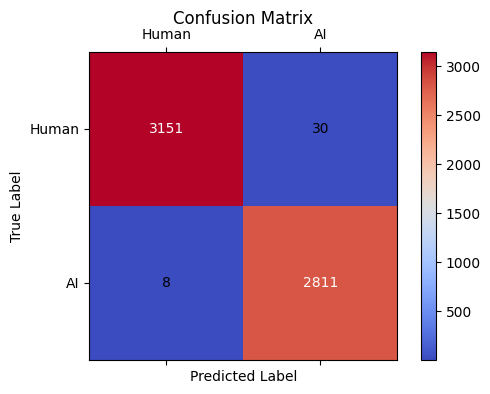

In [ ]:
import matplotlib.pyplot as plt
conf_matrix = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(6, 4))
cax = ax.matshow(conf_matrix, cmap='coolwarm')
plt.title('Confusion Matrix', pad=20)
fig.colorbar(cax)


for (i, j), val in np.ndenumerate(conf_matrix):
    ax.text(j, i, f"{val}", ha='center', va='center', color="white" if val > conf_matrix.max() / 2 else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks([0, 1], ['Human', 'AI'])
plt.yticks([0, 1], ['Human', 'AI'])

plt.show()


### Distribuição das Probabilidades


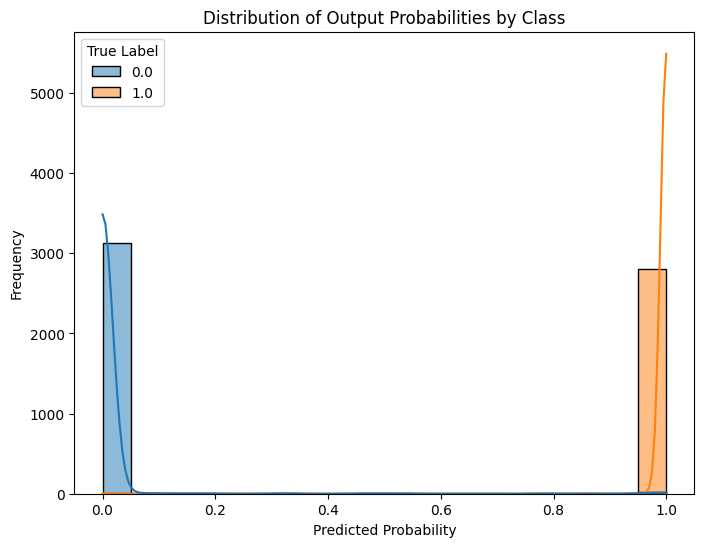

In [ ]:
import seaborn as sns

# Plotting the probability distributions
plt.figure(figsize=(8, 6))
sns.histplot(data={'Probability': y_pred_prob, 'True Label': y_true}, x='Probability', hue='True Label', bins=20, kde=True)
plt.title('Distribution of Output Probabilities by Class')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

Aqui, vemos que foi possível determinar 0 ('Human') e 1 ('AI') para as probabilidades, já que os valores das probabilidades dificilmente ficam no "meio termo" (0.5). Para quase a totalidade dos inputs, o nosso modelo de aprendizado tem uma noção bem certeza se aquilo é gerado por IA ou por um humano.

In [ ]:
y_pred = np.array(y_pred)  # Converte para array caso seja uma lista
count_ones = np.sum(y_pred == 1)
count_zeros = np.sum(y_pred == 0)

print(f"Quantidade de 1: {count_ones}")
print(f"Quantidade de 0: {count_zeros}")


Quantidade de 1: 2841
Quantidade de 0: 3159


Fontes:

https://www.youtube.com/watch?v=Dh9CL8fyG80

https://pytorch.org/tutorials/beginner/data_loading_tutorial

Notebook de inspiração:

https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb